# Project Objectives
- Document code, process, findings, and key takeaways.
- Make your process repeateable and your report (notebook) easy to read and follow.
- Ask exploratory questions of your data. Answer questions through charts and statistical tests.
- Construct a model to predict Value ("tax assessment") using classification techniques.
- Refine your work into a Report.
- Be prepared to answer panel questions.

## Business Goals
- Find drivers for tax assessment with zillow data. What are features that can help predict tax assessment?
- Construct a ML classification model that accurately predicts tax assessment.
- Deliver a report that a non-data scientist can read through and understand what steps were taken, why and what was the outcome?

In [1]:
#import warnings
#warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import scipy.stats as stats
import sklearn.impute as simpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,PolynomialFeatures,QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor



import acquire
import prepare
import explore
import wrangle
import modeling
import env

In [2]:
df0 = acquire.get_zillow_single_fam_2017()

> - ## Acquired the data

In [3]:
df = prepare.prep_zillow(df0)

> - removed whitespace, renamed FIPS codes, renamed columns to easier to read formatting
> - ## Returning a prep file

In [4]:
##checking the distribution after removing outliers
df,train,validate,test = wrangle.wrangle_zillow_orig(df)

prepared df shape: (40707, 11)
train shape: (24423, 11)
validate shape: (8142, 11)
test shape: (8142, 11)


> - removed outliers using Tukey (k=1.5)
> - added a binned version of years (decades)
> - created a new column called "openness", this is the area of the house divided by bathrooms + bedrooms, a rough idea of how spacious the house may be
> - created a new column called "yard ratio", this is how many of that house would fit into the lot
> - split data
> - ## Returning a wrangle file with some feature engineering

-
-
-

> - ## do univariate exploration

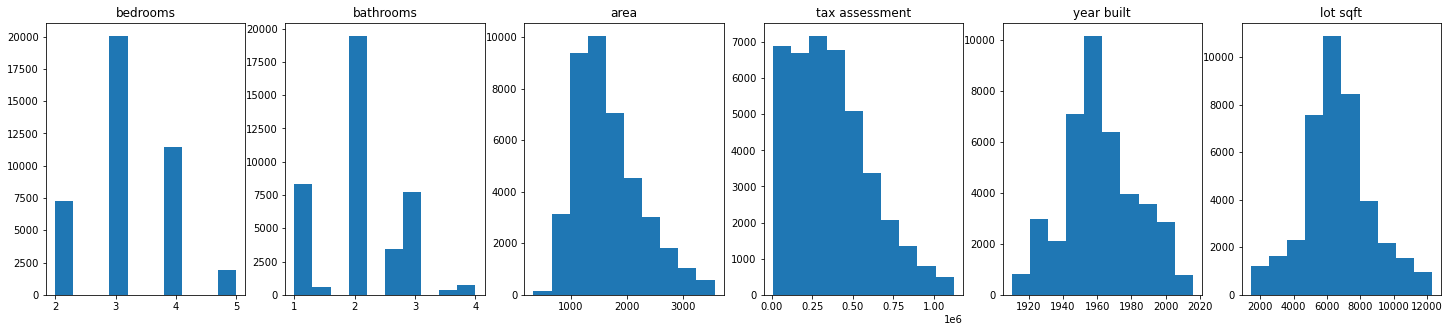

In [5]:
#exploring our basic info
explore.univariate_explore(df[["bedrooms","bathrooms","area","tax assessment", "year built","lot sqft"]])

# Takeaway
here we see most things are somewhat normally distributed with barthrooms being a bit of an outlier in that remark (looks like due to half baths)

-
-
-
-
-
-
-
-
-
-

## This section will be going over exploration

### Bivariate exploration

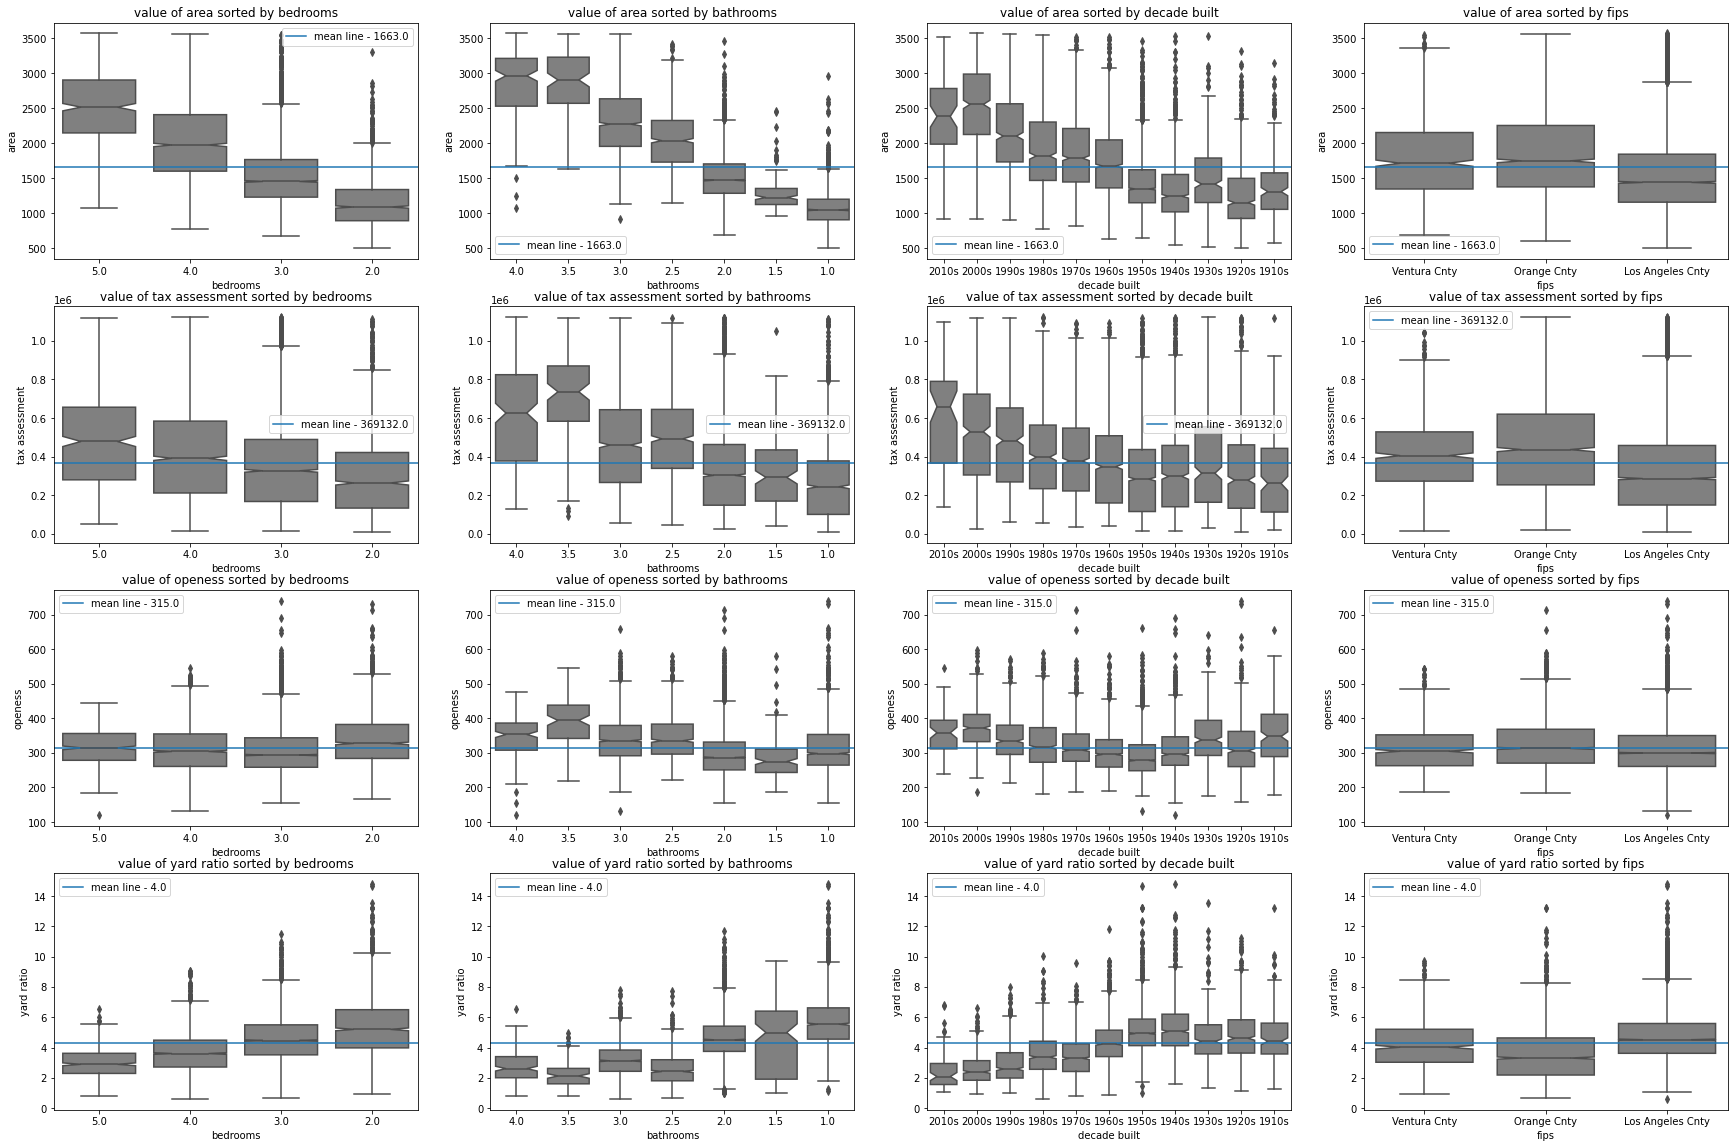

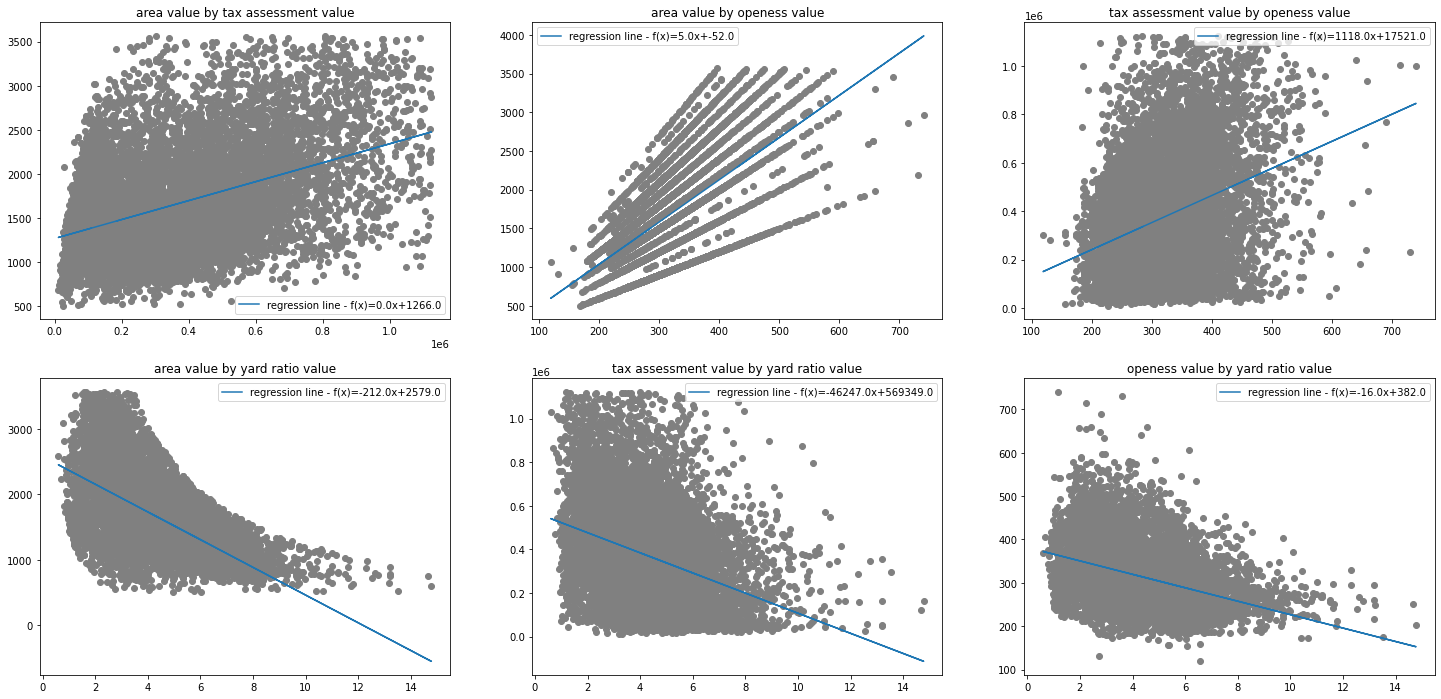

In [6]:
## i break my columns into categorical and numerical variables
cat_vars = ["bedrooms", "bathrooms", "decade built", "fips"] # the categorical variables
num_vars = ["area", "tax assessment", "openess","yard ratio"] # the numerical variables

# i then plot them out using an explore.py created just for this purpose
explore.plot_categorical_and_continuous_vars(train.sample(n=10000, random_state=123),num_vars,cat_vars)
explore.plot_variable_pairs(train.sample(n=10000, random_state=123),num_vars)

# Takeaways
> - more area often has more bathrooms which trends with more bathrooms in turn related with higher tax assessment
> - 3.5 bathrooms is assessmentd highly
> - Orange Cnty has below average yard ratio (urban living?)
> - general trend of area increasing with each decade

# We see there are a few relations, so let's dive deeper into how they're related with a correlation heat map

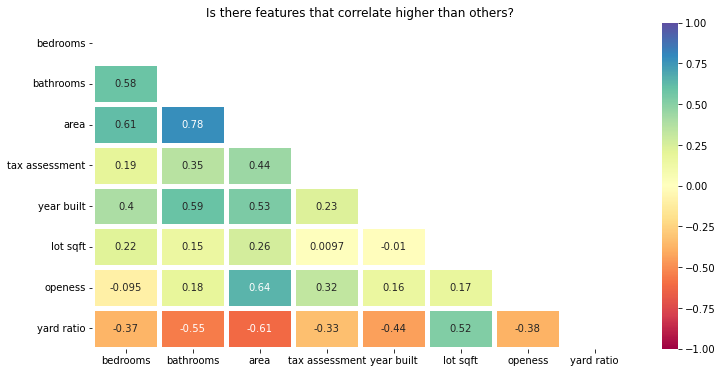

In [7]:
## create a heatmap of relationships between the variables
explore.heatmap_corr(train.sample(n=10000, random_state=123))

# Heatmap takeaways:
no particularly strong relations with tax assessment (our target), will need to use many features to help predict.

Area is well related to bedrooms and bathrooms, with the it being the strongest relation for tax assessment.
Lot sqft has almost 0 relation to tax assessment, this is also curious 

-
-
-

## Let's start asking our questions

> - **Hypothesis 1 -** 
> - alpha = .05
> - $H_0$ = "The distributions underlying the samples of Tax assessment and Openess are unrelated"
> -
> - $H_a$: "The distributions underlying the samples of Tax assessment and Openess are related"

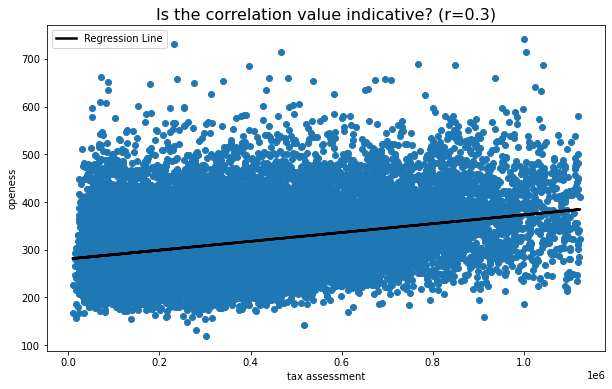

r = 0.31781665743742293

 We reject the null Hypothesis ( T̶h̶a̶t̶ ̶t̶h̶e̶ ̶d̶i̶s̶t̶r̶i̶b̶u̶t̶i̶o̶n̶s̶ ̶u̶n̶d̶e̶r̶l̶y̶i̶n̶g̶ ̶t̶h̶e̶ ̶s̶a̶m̶p̶l̶e̶s̶ ̶o̶f̶ ̶t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶a̶n̶d̶ ̶o̶p̶e̶n̶e̶s̶s̶ ̶a̶r̶e̶ ̶u̶n̶r̶e̶l̶a̶t̶e̶d̶ ) p=0.00000


In [8]:
## data is quantative, mostly normally distributed, and already removed most the outliers
## so will test with pearsonR

explore.pearsonr_corr_explore_plot(train,"tax assessment","openess")

### Correlation/PearsonR takeaway
- here we have a statistical test of PearsonR validating that there is a loose relationship between Tax assessment and Openess with a relationship of .3. this will be useful knowledge in our modelling

-
-
-

Continuing exploration of the heat map, we will test the Tax assessment mean of each FIPs to see if there is a difference in the means based on location

> - **Hypothesis 2 -** 
> - alpha = .05
> - $H_0$ = "Tax assessment of FIPS has identical average assessments to Tax assessment of other FIPS"
> - $\mu_{Tax assessment (FIPS_{n})} <= \mu_{Tax assessment (FIPS_{n+1})}$.
> -
> - $H_a$: "Tax assessment of FIPS is not equal to Tax assessment of other FIPS"
> - $\mu_{Tax assessment (FIPS_{n})} > \mu_{Tax assessment (FIPS_{n+1})}$. 

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=71.69791, p=0.00000

 We reject the null Hypothesis ( t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶f̶i̶p̶s̶O̶r̶a̶n̶g̶e̶ ̶C̶n̶t̶y̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶f̶i̶p̶s̶L̶o̶s̶ ̶A̶n̶g̶e̶l̶e̶s̶ ̶C̶n̶t̶y̶ ) t=21.12025, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=12.50479, p=0.00041

 We reject the null Hypothesis ( t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶f̶i̶p̶s̶V̶e̶n̶t̶u̶r̶a̶ ̶C̶n̶t̶y̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶f̶i̶p̶s̶L̶o̶s̶ ̶A̶n̶g̶e̶l̶e̶s̶ ̶C̶n̶t̶y̶ ) t=9.88320, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=72.80297, p=0.00000

 We r

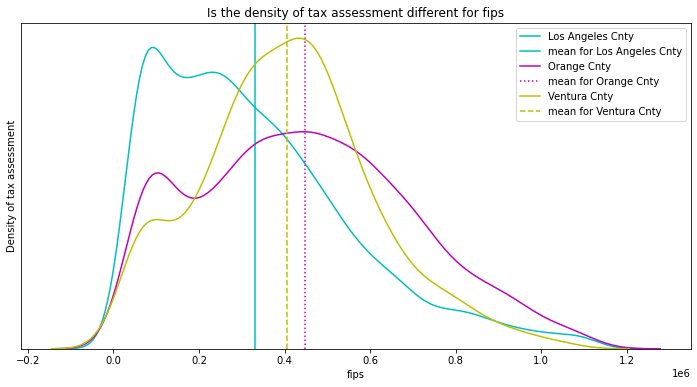

In [9]:
## will do test for homogeneity of variance and pass as flag to TTest using levene test
## samples are sufficent size, and mostly normally distributed


explore.cat_and_num_explore_plot(train.sample(n=10000, random_state=123),"fips","tax assessment")

> - ## Takeaway on TTest for FIPS and Tax assessment
> - the 2 sided TTest yielded interesting results in that the the samples of FIPS did varied enough to pass our measure of statistical significance (alpha = .05); rejecting our null hypothesis. This would indicate that seperating the data by FIPS will result in a significant difference. This will be important for our modeling

-
-
-
-
-

> - **Hypothesis 3 -** 
> - alpha = .05
> - $H_0$ = "Amount of bedrooms is independant of the amount bathrooms"
> - $H_a$:  "Amount of bedrooms is not independant of the amount bathrooms"

In [10]:
explore.chi2_for_two(train.bedrooms,train.bathrooms)

---
chi^2 = 11401.5412, p = 0.00000, degf = 18
due to p = 0.00000 < α = 0.05 we reject our null hypothesis
( b̶e̶d̶r̶o̶o̶m̶s̶ ̶i̶s̶ ̶i̶n̶d̶e̶p̶e̶n̶d̶a̶n̶t̶ ̶o̶f̶ ̶b̶a̶t̶h̶r̶o̶o̶m̶s̶ )


> - ## Takeaway on CHI2 for Bedrooms and Bathroom
> - The CHI^2 test provided a statistically significant result that allows us to reject our null hypothesis that bedrooms is independant of bathrooms, signifiying that there is a relationship that we can utilize in our modeling (openess)

> - **Hypothesis 4 -** 
> - alpha = .05
> - $H_0$ = "Tax assessment of Area has identical average assessments to Tax assessment of other Areas"
> - $\mu_{Tax assessment (Area_{n})} = \mu_{Tax assessment (Area_{n+1})}$.
> -
> - $H_a$: "Tax assessment of Area is not equal to Tax assessment of other Area"
> - $\mu_{Tax assessment (Area_{n})}  /= \mu_{Tax assessment (Area_{n+1})}$. 

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=362.86923, p=0.00000

 We reject the null Hypothesis ( t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶a̶r̶e̶a̶ ̶b̶i̶n̶n̶e̶d̶<̶2̶5̶%̶ ̶p̶e̶r̶c̶e̶n̶t̶i̶l̶e̶ ̶a̶r̶e̶a̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶a̶r̶e̶a̶ ̶b̶i̶n̶n̶e̶d̶2̶5̶%̶~̶5̶0̶%̶ ̶p̶e̶r̶c̶e̶n̶t̶i̶l̶e̶ ̶a̶r̶e̶a̶ ) t=-27.79397, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=221.92842, p=0.00000

 We reject the null Hypothesis ( t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶a̶r̶e̶a̶ ̶b̶i̶n̶n̶e̶d̶5̶0̶%̶~̶7̶5̶%̶ ̶p̶e̶r̶c̶e̶n̶t̶i̶l̶e̶ ̶a̶r̶e̶a̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶t̶a̶x̶ ̶a̶s̶s̶e̶s̶s̶m̶e̶n̶t̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶a̶r̶e̶a̶ ̶b̶i̶n̶n̶e̶d̶2̶5̶%̶~̶5̶0̶%̶ ̶p̶e̶r̶c̶e̶n̶t̶i̶l̶e̶ ̶a̶r̶e̶a̶ ) t=32.46823, p=0.00000
-----------------------

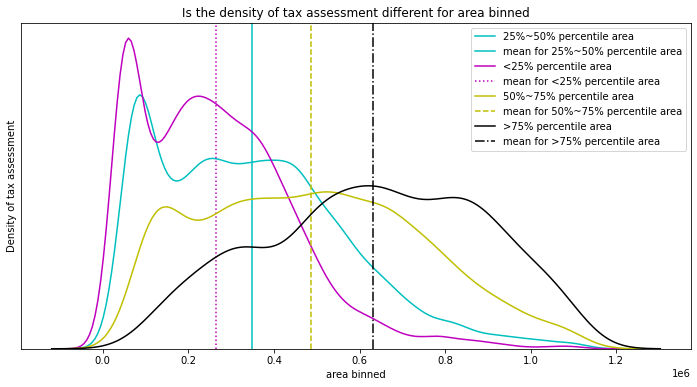

In [11]:
train["area binned"] = pd.cut(train.area,4,labels=["<25% percentile area","25%~50% percentile area","50%~75% percentile area",">75% percentile area"])

explore.cat_and_num_explore_plot(train,"area binned","tax assessment")

> - ## Takeaway on TTest for Tax assessment by area percentile
> - the 2 sided TTest yielded interesting results in that the the samples of Area percentile yielded a varied enough Signal/Noise ratio to have statistical significance (alpha = .05); rejecting our null hypothesis. This would indicate that utilizing area (or its derivative "openess") to help predict Tax Assessment would be beneficial

-
-
-
-
-

# Verify feature selection going into modeling
we see above that most of our features have bearing on assessment, we will drop decade built since it is more explicitly shown in year built.

we will also run SelectKbest and Recursive Feature Elimination as a sanity check

In [12]:
df.drop(columns="decade built",inplace=True)
X_train, y_train, X_validate, y_validate, X_test, y_test, train, validate, test = wrangle.split_tvt_continuous(df,"tax assessment")

train -> (24423, 10)
validate -> (8142, 10)
test -> (8142, 10)


In [13]:
print("-----------------------------\n")
wrangle.select_kbest(X_train.drop(columns="fips"),y_train,3)
print("^^^^^^^^^^^^KBest^^^^^^^^^^\n")
print("-----------------------------\n")
print("vvvvvvvvvvvvvRFEvvvvvvvvvvvvv")
wrangle.rfe(X_train.drop(columns="fips"),y_train,3)

-----------------------------

['bathrooms', 'area', 'yard ratio']
^^^^^^^^^^^^KBest^^^^^^^^^^

-----------------------------

vvvvvvvvvvvvvRFEvvvvvvvvvvvvv
            rfe_ranking
bedrooms              1
bathrooms             1
yard ratio            1


Var  Rank
0    bedrooms     1
1   bathrooms     1
7  yard ratio     1
6     openess     2
2        area     3
3  year built     4
4    lot sqft     5
5         zip     6

# Takeaways
Some of our features have a good correlation or weight in deciding Tax Assessment and we will keep them for modeling, while others we will drop

-
-
-
-
-
-
-
-
-
-

# Modeling
After reviewing the exploratory analysis we will drop FIPS, this is due to using Zip which is a more accurate representation of geographic area. we will also drop lot sqft due to low relation value with Tax assessment

In [14]:
xlist = train.drop(columns=["tax assessment","fips","lot sqft"]).columns.tolist()

X_train, X_validate, X_test = train[xlist], validate[xlist], test[xlist]
y_train, y_validate, y_test = train["tax assessment"], validate["tax assessment"], test["tax assessment"]

#scaler = MinMaxScaler()
#
#X_train_scaled = scaler.fit_transform(X_train) ##only use fit_transform for training, after that use transform (equations are created)
#X_validate_scaled = scaler.transform(X_validate)
#X_test_scaled = scaler.transform(X_test)

scaler = RobustScaler(with_centering=True,quantile_range=(10,90),unit_variance=True)

X_train_scaled = scaler.fit_transform(X_train) ##only use fit_transform for training, after that use transform (equations are created)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

RMSE using Mean
Train/In-Sample:  239064.38 
Validate/Out-of-Sample:  240583.14
RMSE using Median
Train/In-Sample:  241436.71 
Validate/Out-of-Sample:  242934.62


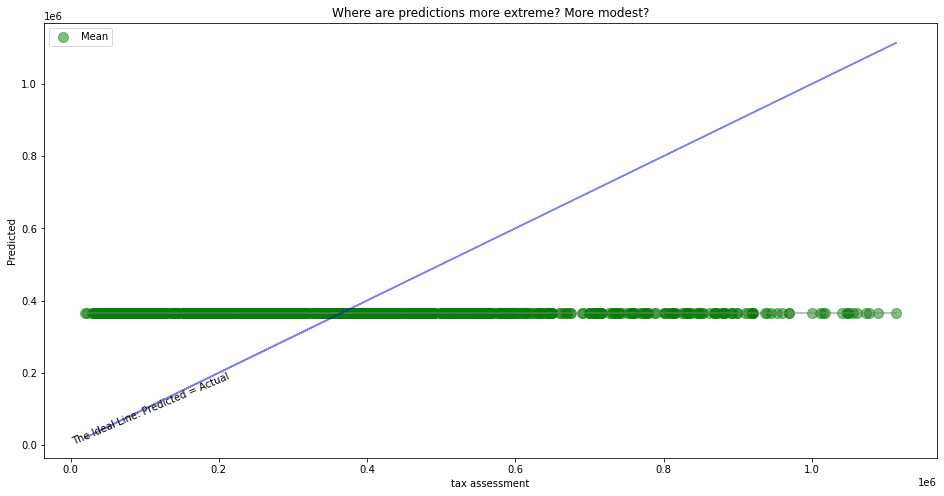

In [15]:
y_train,y_validate,metric_df = modeling.model_baseline(y_train,y_validate,"tax assessment")

# Baseline modeling takeaways
we ran two basic models using the mean and the median, and utilized the Root Mean Squared Error as the determinate for which to keep moving forward (lowest value). This time it was Mean, with a RMSE of apporx 240k

RMSE for Polynomial Model, degrees=4
Training/In-Sample:  198804.6413136512 
Validation/Out-of-Sample:  201191.1746497485


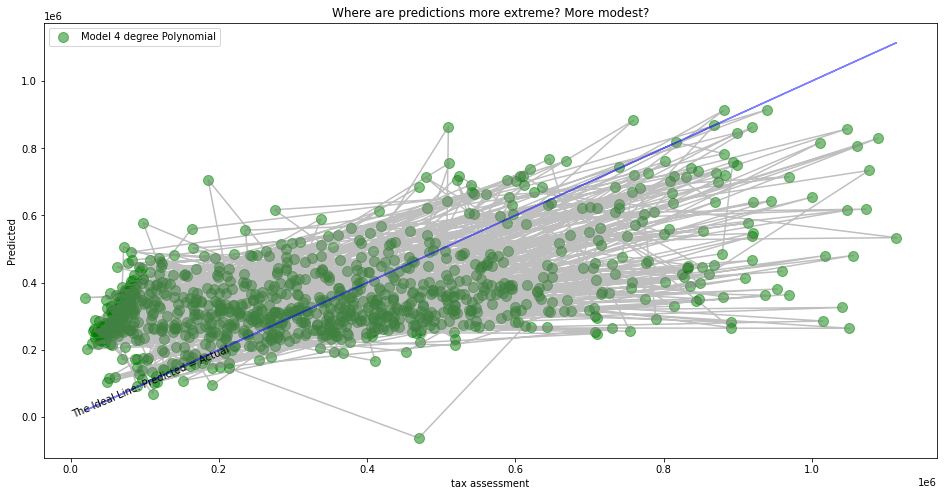

model     rmse_train  rmse_validate  r^2_validate
0          baseline_mean  239064.384317  240583.137891      0.000000
1  Polynomial - degree 4  198804.641314  201191.174650      0.300681

In [16]:
y_train,y_validate,temp = \
        modeling.model_polynomial(X_train_scaled,X_validate_scaled,y_train,y_validate,"tax assessment",4)

metric_df = pd.concat([metric_df,temp],axis=0).reset_index(drop=True)
   
metric_df

In [17]:
##want smallest error

rmse_mean_train = mean_squared_error(y_train["tax assessment"], y_train["mean"])**(1/2)
rmse_mean_validate = mean_squared_error(y_validate["tax assessment"], y_validate["mean"])**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_mean_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_mean_validate, 2))


rmse_median_train = mean_squared_error(y_train["tax assessment"], y_train["median"])**(1/2)
rmse_median_validate = mean_squared_error(y_validate["tax assessment"], y_validate["median"])**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_median_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_median_validate, 2))

RMSE using Mean
Train/In-Sample:  239064.38 
Validate/Out-of-Sample:  240583.14
RMSE using Median
Train/In-Sample:  241436.71 
Validate/Out-of-Sample:  242934.62


In [18]:
# create the model object
linreg = LinearRegression()

# fit the model to our training data. 
linreg.fit(X_train_scaled, y_train["tax assessment"])

# predict train
y_train['tip_pred_linreg'] = linreg.predict(X_train_scaled)

# evaluate: rmse
rmse_linreg_train = mean_squared_error(y_train["tax assessment"], y_train.tip_pred_linreg)**(1/2)

# predict validate
y_validate['tip_pred_linreg'] = linreg.predict(X_validate_scaled)

# evaluate: rmse
rmse_linreg_validate = mean_squared_error(y_validate["tax assessment"], y_validate.tip_pred_linreg)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_linreg_train, 
      "\nValidation/Out-of-Sample: ", rmse_linreg_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  213083.66851726494 
Validation/Out-of-Sample:  213120.71690143965


In [19]:
metric_df.loc[len(metric_df.index)] = ["OLS lm 1",
                                        rmse_linreg_train, rmse_linreg_validate,
                                        explained_variance_score(y_validate["tax assessment"],y_validate["tip_pred_linreg"])
                                    ]

In [20]:
# create the model object
l_lars = LassoLars(alpha=0,normalize=False)

# fit the model to our training data. 
l_lars.fit(X_train_scaled, y_train["tax assessment"])

# predict train
y_train['tip_pred_l_lars'] = l_lars.predict(X_train_scaled)

# evaluate: rmse
rmse_l_lars_train = mean_squared_error(y_train["tax assessment"], y_train.tip_pred_l_lars)**(1/2)

# predict validate
y_validate['tip_pred_l_lars'] = l_lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_l_lars_validate = mean_squared_error(y_validate["tax assessment"], y_validate.tip_pred_l_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_l_lars_train, 
      "\nValidation/Out-of-Sample: ", rmse_l_lars_validate)

metric_df.loc[len(metric_df.index)] = ["Lasso lars 1",
                                        rmse_l_lars_train, rmse_l_lars_validate,
                                        explained_variance_score(y_validate["tax assessment"],y_validate["tip_pred_l_lars"])
                                    ]
metric_df

RMSE for Lasso + Lars
Training/In-Sample:  213083.66851726494 
Validation/Out-of-Sample:  213120.71690143965


model     rmse_train  rmse_validate  r^2_validate
0          baseline_mean  239064.384317  240583.137891      0.000000
1  Polynomial - degree 4  198804.641314  201191.174650      0.300681
2               OLS lm 1  213083.668517  213120.716901      0.215269
3           Lasso lars 1  213083.668517  213120.716901      0.215269

In [21]:
# create the model object
glm = TweedieRegressor(power=0,alpha=0)

# fit the model to our training data. 
glm.fit(X_train_scaled, y_train["tax assessment"])

# predict train
y_train['tip_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_glm_train = mean_squared_error(y_train["tax assessment"], y_train.tip_pred_glm)**(1/2)

# predict validate
y_validate['tip_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_glm_validate = mean_squared_error(y_validate["tax assessment"], y_validate.tip_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_glm_train, 
      "\nValidation/Out-of-Sample: ", rmse_glm_validate)
    
metric_df.loc[len(metric_df.index)] = ["Tweedie 1",
                                        rmse_glm_train,rmse_glm_validate,
                                        explained_variance_score(y_validate["tax assessment"],y_validate["tip_pred_glm"])
                                    ]

metric_df

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  213083.66851726564 
Validation/Out-of-Sample:  213120.7168410496


model     rmse_train  rmse_validate  r^2_validate
0          baseline_mean  239064.384317  240583.137891      0.000000
1  Polynomial - degree 4  198804.641314  201191.174650      0.300681
2               OLS lm 1  213083.668517  213120.716901      0.215269
3           Lasso lars 1  213083.668517  213120.716901      0.215269
4              Tweedie 1  213083.668517  213120.716841      0.215269

In [22]:
import plotly.express as px

fig = px.histogram(y_train,
            x=y_train.drop(columns=["mean","median"]).columns.tolist(),
            barmode="overlay",
            #histfunc="avg",
            #color=cat,
            color_discrete_map = {0:'red',1:'orange',2:'yellow',3:'green',4:'blue',5:'indigo',6:'purple'})
fig.show()

## Opting to use Polynomial Regression for the final test predictions
- almost all the other model performances where similar to each other, with this one being an outlier having an average RMSE roughly 17% less than baseline